# A ideia aqui é fazer um detector de apenas uma classe através de um regressão simples, estarei utilizando a arquitetura da VGG16 para extração de características, e concatenando as demais camadas necessárias para regressão do centróide da localização do Wally

In [1]:
import os
import cv2
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
annots_path = "ReferenceData/wheres_wally_train.csv"
train_path = "TrainingSet/"
test_path = "TestSet/"

In [3]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 16

## Carregando imagens e rótulos do disco, a dimensão definida é de 224x224 (A mesma usada originalmente na VGG16)

In [4]:
rows = open(annots_path).read().strip().split("\n")
data = []
targets = []

for row in rows:
    # break the row into the filename and bounding box coordinates
    (filename, X, Y) = row.split(",")
    imagePath = train_path + filename
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    X = float(X) / w
    Y = float(Y) / h    
    image = cv2.resize(image,(224,224))
    data.append(image)
    targets.append((X, Y))

## Tratamento dos vetores de entrada, saída e divisão do conjunto de validação

In [5]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

(trainX, valX, trainY, valY) = train_test_split(data, targets, test_size=0.2, random_state=42)

## Neste ponto é configurada a arquitetura da rede neural utilizada para a solução, aproveitando a VGG16 para extração de características e adicionando camadas completamente conectadas para inferir as posições do centroide com saída em 1x2 dimensões

In [6]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# flatten the max-pooling output of VGG
flatten = Flatten()(vgg.output)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(2, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)
model.compile(loss="mse", optimizer=Adam(lr=INIT_LR))

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Treinamento (executado em GPU)

In [8]:
H = model.fit(trainX, trainY, validation_data=(valX, valY), batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1)

Epoch 1/20
6/6 [==============================] - 3s 471ms/step - loss: 0.0344 - val_loss: 0.0102
Epoch 2/20
6/6 [==============================] - 1s 238ms/step - loss: 0.0107 - val_loss: 0.0115
Epoch 3/20
6/6 [==============================] - 1s 237ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 4/20
6/6 [==============================] - 1s 237ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/20
6/6 [==============================] - 1s 241ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/20
6/6 [==============================] - 1s 241ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/20
6/6 [==============================] - 1s 237ms/step - loss: 8.8589e-04 - val_loss: 0.0015
Epoch 8/20
6/6 [==============================] - 1s 237ms/step - loss: 4.6777e-04 - val_loss: 0.0012
Epoch 9/20
6/6 [==============================] - 1s 248ms/step - loss: 3.2086e-04 - val_loss: 0.0012
Epoch 10/20
6/6 [==============================] - 2s 251ms/step - loss: 2.5070e-04 - val_loss: 0.0010
Epo

## A checagem da curva de perda nos conjuntos de treino e validação em relação as épocas é um otimo indicativo sobre anomalias no treinamento, no nosso caso ocorreu tudo bem

In [9]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in H.history.items()]
plt.legend()
plt.show()

## Momento de conferir como o modelo se comportou no conjunto de testes, neste momento também é feita a produção do CSV com as posições dos centróides inferidos


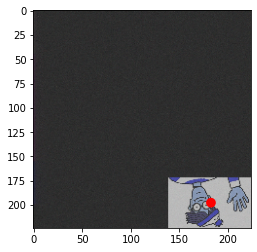

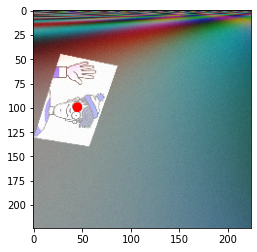

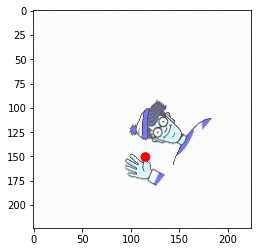

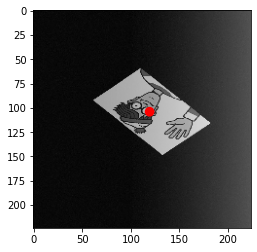

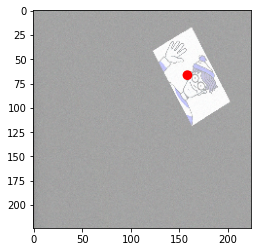

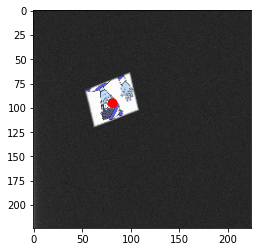

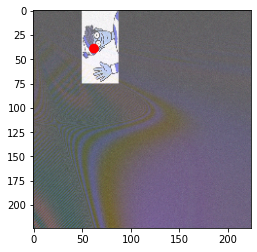

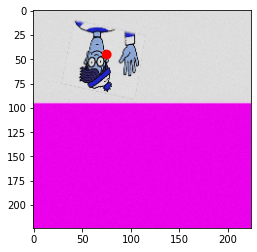

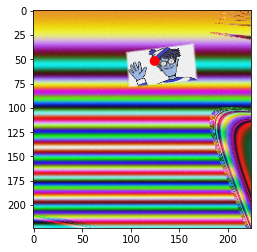

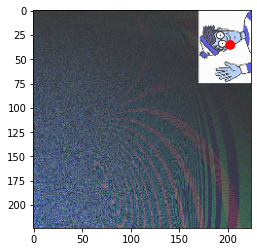

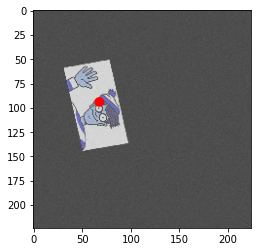

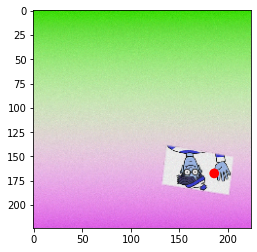

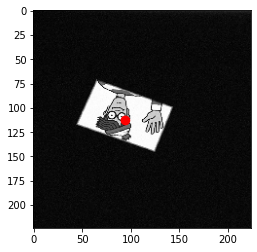

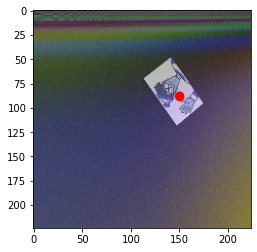

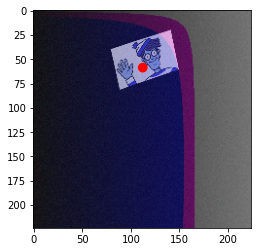

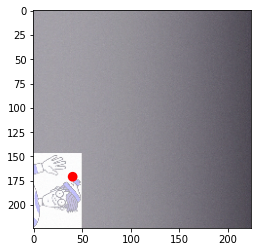

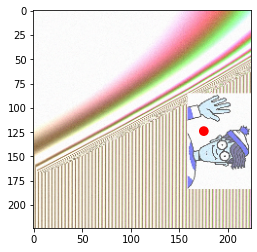

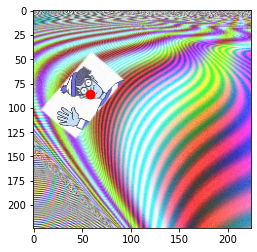

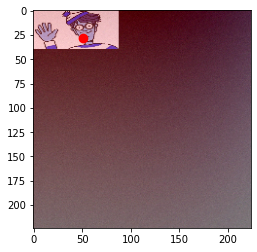

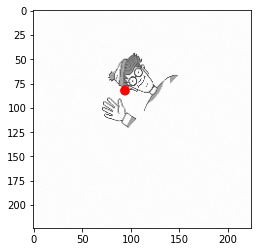

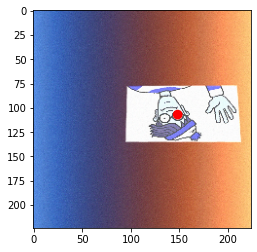

In [16]:
from matplotlib.patches import Circle

with open("wheres_wally_test.csv", "w") as f:
    for img in os.listdir(test_path):
        image = cv2.imread(test_path+img)
        image = cv2.resize(image, (224,224)).astype('float32') / 255
        input_img = np.expand_dims(image, axis=0)

        res = model.predict(input_img)[0]
        (X, Y)= (res[0]*image.shape[1], res[1]*image.shape[0])

        fig,ax = plt.subplots(1)
        ax.imshow(image)    
        circ = Circle((X,Y),5,fc="r")
        ax.add_patch(circ)
        plt.show()
        
        f.write(img+","+str(round(X))+","+str(round(Y))+"\n")